# Label Engineering and Exploratory model training
___

In [2]:
# mount google drive if running in colab
import os
import sys

if os.path.exists('/usr/lib/python3.6/'):
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append('/content/drive/My Drive/Colab Notebooks/Starbucks_Udacity')
    %cd /content/drive/My Drive/Colab Notebooks/Starbucks_Udacity/notebooks/exploratory
else:
    sys.path.append('../../')

In [3]:
import numpy as np
import os
import pandas as pd
import joblib
import progressbar
import re
import datetime
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# importing scripts
%load_ext autoreload
%autoreload 2
%aimport src.data.make_dataset 
%aimport src.utilities.helper
%aimport src.features.build_features

from src.features.build_features import date_features
from src.data.make_dataset import save_file

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [4]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import progressbar
import catboost
import joblib
from catboost import CatBoostClassifier
from catboost import Pool
from sklearn.preprocessing import LabelEncoder
from catboost import MetricVisualizer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import train_test_split

import shap
shap.initjs()
import timeit

from sklearn.model_selection import train_test_split, GroupShuffleSplit, GridSearchCV, GroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
from xgboost.sklearn import XGBRegressor, XGBClassifier
from imblearn.over_sampling import SMOTE

from catboost.utils import select_threshold
from catboost.utils import get_roc_curve
from catboost.utils import get_fpr_curve
from catboost.utils import get_fnr_curve

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, GroupShuffleSplit
import seaborn as sns

%load_ext autoreload
%autoreload 2
%aimport src.models.train_model
%aimport src.data.make_dataset

%aimport src.utilities.cf_matrix

from src.data import make_dataset
from src.utilities import cf_matrix
from src.data.make_dataset import save_file
from src.models import train_model
from src.models.train_model import grid_search_results, generate_folds, show_model_results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
df = joblib.load('../../data/interim/transcript_final_optimised.joblib')

In [6]:
df

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,received_spend,viewed_spend,viewed_days_left,remaining_to_complete,viewed_in_valid,viewed,last_transaction_days,spend>required,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,a,b,c,d,e,f,g,h,i,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9,viewed_0,viewed_1,viewed_2,viewed_3,viewed_4,viewed_5,viewed_6,viewed_7,viewed_8,viewed_9,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,amount_7,amount_14,amount_17,amount_21,amount_24,amount_30,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30,offer_spend,completed,percentage_offer_active,offer_active_count,no_offer_count,offer_cum_amount,no_offer_cum_amount,amount_per_day_offer,amount_per_day_not_offer
0,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,1,5,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,37.67,6.75,5.0,1.0,1.0,NaN,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,37.67,1.0,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
1,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,9,0.0,0.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,1.0,7.0,16,1,5,2017,17.78,37.67,37.67,37.67,37.67,37.67,1.0,2.0,2.0,2.0,2.0,2.0,17.78,0.00,49.39,1.00,0.0,1.0,1.0,1.00,1,5.0,5.0,5.0,5.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,0.00,NaN,NaN,NaN,NaN,,,,,,,49.39,0.0,0.758621,5.50,1.75,19.89,17.78,3.616364,10.160000
2,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,17.0,26,4,5,2017,0.00,23.93,53.65,110.99,110.99,110.99,0.0,1.0,2.0,5.0,5.0,5.0,23.93,0.00,48.28,7.00,10.0,1.0,1.0,1.25,1,5.0,5.0,5.0,5.0,1.0,2.0,1.0,0.0,1.0,2.0,0.0,87.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.0,NaN,NaN,j,,,,,,48.28,1.0,0.318841,5.50,11.75,19.89,91.10,3.616364,7.753191
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0.0,0.0,1.0,3.0,5.0,5.0,23.93,48.28,0.00,0.00,0.0,1.0,1.0,5.25,1,15.0,15.0,15.0,15.0,2.0,3.0,2.0,0.0,1.0,3.0,0.0,135.34,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,48.28,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.0,0.00,NaN,j,,b,,,,48.28,1.0,0.458824,9.75,11.50,19.89,91.10,2.040000,7.921739
4,a03223e636434f42ac4c3df47e8bac43,NaN,NaN,-356,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,4,4,8,2017,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.00,1.09,9.75,20.0,1.0,1.0,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,1.09,0.0,0.000000,0.00,0.00,0.00,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

# Label Creation

We can define labels to categorise offers by 7 mutually exclusive options:

1. Completed without being viewed at all
2. Completed before being viewed
3. Completed and viewed, however spending when viewed was not increased above non view spending rate
4. Completed. When viewed, spending increased above base spending rate
5. Incomplete. When viewed, spending increased above base spending rate
6. Incomplete, viewed, spending increased above base rate
7. Didn't complete or view

In [6]:
def label_creater(df, label_grid=None):
    
    '''
    Creates prediction label column based on label_grid dictionary criteria
        
    Parameters
    -----------
    df:  DataFrame
    label_grid: dictionary to assign labels
            
    Returns
    -------
    DataFrame
    '''  
       
    
    df['completed_not_viewed'] = ((df.completed == 1) & (df.viewed == 0)) * label_grid['completed_not_viewed']
    
    df['completed_before_viewed'] = (((df.completed == 1) & (df.viewed == 1)) 
                                       & (df.received_spend > df.difficulty)
                                     ) * label_grid['completed_before_viewed']
    
    # Required completion spending per time left < base rate
    df['complete_anyway'] = (((df.completed == 1) & (df.viewed == 1)) 
                                & (df.viewed_spend / df.viewed_days_left <= df.amount_per_day_not_offer)
                             )* label_grid['complete_anyway']
    
    # Required completion spending per time left > base rate
    df['completed_responsive'] = (((df.completed == 1) & (df.viewed == 1) & ~(df.received_spend > df.difficulty))
                                 & (((df.viewed_spend / df.viewed_days_left > df.amount_per_day_not_offer) 
                                    | (pd.isna(df.amount_per_day_not_offer) 
                                       & ~(df.received_spend > df.difficulty))
                                    )))* label_grid['completed_responsive']
    
    # Didn't complete, spending wasn't increased above base spending
    df['incomplete_responsive'] = (((df.completed == 0) & (df.viewed == 1)) 
                                     & ((((df.viewed_spend / df.viewed_days_left) > df.amount_per_day_not_offer))
                                       | ((df.viewed_spend > 0) & pd.isna(df.amount_per_day_not_offer)
                                         )))* label_grid['incomplete_responsive']
        
    df['no_complete_no_view'] = ((df.completed == 0) & (df.viewed == 0))* label_grid['no_complete_no_view']
    
    df['unresponsive'] = ((df['completed_not_viewed']==0) & 
                          (df['completed_before_viewed']==0) & 
                          (df['complete_anyway']) & 
                          (df['completed_responsive']) & 
                          (df['incomplete_responsive']) & 
                          (df['no_complete_no_view'])
                          )* label_grid['unresponsive']  
    
    
    df['label'] = df[['completed_not_viewed', 'completed_before_viewed', 'complete_anyway', 'completed_responsive',
       'incomplete_responsive', 'unresponsive', 'no_complete_no_view']].sum(axis=1)
    
    df.drop(['received_spend',
            'viewed_spend',
            'viewed_days_left',
            'remaining_to_complete',
            'viewed_in_valid',
            'viewed',
            'spend>required',
            'offer_spend',
            'completed',
            'completed_not_viewed',
            'completed_before_viewed',
            'complete_anyway',
            'completed_responsive',
            'incomplete_responsive',
            'no_complete_no_view',
            'unresponsive',], axis=1, inplace=True)
    
    return df

### 2.1 Dropping features that give direct information about completion
To build a model that can predict whether future offers will be completed we need to drop any features that provide data leakage.

Hence we drop the following:

* received_spend
* viewed_spend
* viewed_days_left
* remaining_to_complete
* viewed_in_valid
* viewed
* spend>required
* offer_spend
            
The following are converted into a single feature label: 'label'. 
The original features dropped:
            
* completed
* completed_not_viewed
* completed_before_viewe
* complete_anyway
* completed_responsive
* incomplete_responsive
* no_complete_no_view
* unresponsive

### 2.2 Train test strategy

In order to build a predictive model, our test data needs to be in the future relative to our training data. Due to the way our features are built, historical customer data is embedded in each observation, so predicting a previous obesrvation in time for the same customer would not be a true test of the predictive power of the model. 

We will therefore sort the data by 'time_days' and then use train_test_split to split the data without shuffling. 

### 2.3 CatBoost

We will first train models using a CatBoost classifier

CatBoost is a gradient boosting algorithm that has very good default parameters and is particularly effective at using categorical variables out of the box. 
* Statistics and combinations of categorical features are calculated internally and utilised as features in the model. 
* It has good visualisation options with the ability to plot train and test loss in real time as a model trains. 
* Setting early stopping means we do not need to optimize the number of iterations, the model will automatically stop training once test loss starts rising for a given number of iterations. 
* There is GPU support allowing fast training.


Setting default hyper parameters:
* Catboost uses symmetrical trees by default with a depth of 6.
* NaN values do not need to be removed since the model is able to automatically handle these.
* An optimal learning rate is calculated internally by the algorithm based on the dataset provided.
* After initial training exploration we will utilise grid search to further optimize hyper parameters.

In [7]:
# CatBoost requires assignment of categorical features
cat_features = [0,4,5,92,93,94,95,96,97]

In [8]:
df.drop(['received_spend',
        'viewed_spend',
        'viewed_days_left',
        'remaining_to_complete',
        'viewed_in_valid',
        'viewed',
        'spend>required',
        'offer_spend',
        'completed',
        ], axis=1, inplace=True)

# Categorical features are as follows:
df.iloc[:, cat_features].head(10)

,person,gender,id,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30
0,78afa995795e4d85b5d9ceeca43f5fef,0,6,,,,,,
1,78afa995795e4d85b5d9ceeca43f5fef,0,9,,,,,,
2,78afa995795e4d85b5d9ceeca43f5fef,0,1,j,,,,,
3,78afa995795e4d85b5d9ceeca43f5fef,0,7,j,,b,,,
4,a03223e636434f42ac4c3df47e8bac43,0,0,,,,,,
5,a03223e636434f42ac4c3df47e8bac43,0,8,,,,,,
6,a03223e636434f42ac4c3df47e8bac43,0,9,,i,,,,
7,a03223e636434f42ac4c3df47e8bac43,0,0,,i,j,,,
8,a03223e636434f42ac4c3df47e8bac43,0,0,,i,j,a,,
9,e2127556f4f64592b11af22de27a7932,1,4,,,,,,


In [88]:
df = joblib.load('../../data/interim/transcript_final_optimised.joblib')
df = label_creater(df, label_grid=separation)

In [90]:
df[df.label==2]

,person,age,income,signed_up,gender,id,rewarded,difficulty,reward,duration,mobile,web,social,bogo,discount,informational,time_days,day,weekday,month,year,t_1,t_3,t_7,t_14,t_21,t_30,t_1c,t_3c,t_7c,t_14c,t_21c,t_30c,last_amount,last_transaction_days,hist_reward_completed,hist_reward_possible,hist_difficulty_completed,hist_difficulty_possible,hist_previous_completed,hist_previous_offers,hist_viewed_and_completed,hist_complete_not_viewed,hist_failed_complete,hist_viewed,hist_received_spend,hist_viewed_spend,a,b,c,d,e,f,g,h,i,received_0,received_1,received_2,received_3,received_4,received_5,received_6,received_7,received_8,received_9,viewed_0,viewed_1,viewed_2,viewed_3,viewed_4,viewed_5,viewed_6,viewed_7,viewed_8,viewed_9,count_0,count_1,count_2,count_3,count_4,count_5,count_6,count_7,count_8,count_9,amount_7,amount_14,amount_17,amount_21,amount_24,amount_30,offer_7,offer_14,offer_17,offer_21,offer_24,offer_30,percentage_offer_active,offer_active_count,no_offer_count,offer_cum_amount,no_offer_cum_amount,amount_per_day_offer,amount_per_day_not_offer,label
3,78afa995795e4d85b5d9ceeca43f5fef,75.0,100000.0,-443,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0,21.0,30,1,5,2017,0.00,0.00,23.93,73.32,110.99,110.99,0.0,0.0,1.0,3.0,5.0,5.0,23.93,5.25,15.0,15.0,15.0,15.0,2.0,3.0,2.0,0.0,1.0,3.0,0.0,135.34,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,48.28,NaN,NaN,NaN,NaN,37.67,NaN,NaN,49.39,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,37.67,49.39,23.93,0.00,0.00,NaN,j,,b,,,,0.458824,9.75,11.50,19.89,91.10,2.040000,7.921739,2
38,aa4862eba776480b8bb9c68455b8c2e1,61.0,57000.0,-318,0,1,0.0,10.0,10.0,7.0,1.0,0.0,1.0,1.0,0.0,0.0,17.0,28,3,9,2017,0.00,0.00,0.00,12.33,12.33,12.33,0.0,0.0,0.0,1.0,1.0,1.0,12.33,8.25,10.0,15.0,10.0,30.0,1.0,3.0,1.0,0.0,2.0,3.0,0.0,24.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,12.33,NaN,12.33,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,12.33,0.00,0.00,NaN,NaN,c,j,,,,,0.550725,9.50,7.75,12.33,0.00,1.297895,0.000000,2
43,31dda685af34476cad5bc968bdb01c53,62.0,71000.0,-896,0,5,0.0,7.0,3.0,7.0,1.0,1.0,1.0,0.0,1.0,0.0,17.0,28,6,2,2016,12.57,12.57,69.50,69.50,69.50,69.50,1.0,1.0,4.0,4.0,4.0,4.0,12.57,1.00,5.0,10.0,17.0,37.0,2.0,3.0,2.0,0.0,1.0,3.0,0.0,120.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,0.00,NaN,NaN,69.50,NaN,50.76,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,0.00,56.93,12.57,0.00,NaN,NaN,d,f,,,,,0.405797,7.00,10.25,37.44,32.06,5.348571,3.127805,2
68,d53717f5400c4e84affdaeda9dd926b3,88.0,53000.0,-434,0,0,0.0,20.0,5.0,10.0,0.0,1.0,0.0,0.0,1.0,0.0,24.0,11,6,6,2017,0.00,0.00,0.00,7.76,38.83,399.06,0.0,0.0,0.0,1.0,3.0,6.0,7.76,7.50,5.0,7.0,20.0,30.0,1.0,3.0,1.0,0.0,2.0,2.0,0.0,399.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,391.30,NaN,NaN,NaN,7.76,NaN,NaN,NaN,NaN,0.00,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360.23,31.07,7.76,0.00,0.00,0.0,,e,j,,,,0.226804,5.50,18.75,347.45,51.61,63.172727,2.752533,2
101,f082d80f0aac47a99173ba8ef8fc1909,40.0,33000.0,-747,1,6,0.0,5.0,5.0,7.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,9,5,7,2016,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,NaN,NaN,NaN,NaN,,,,,,,0.000000,0.00,0.00,0.00,0.00,NaN,NaN,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76165,50de807eb2234a74a5daf0f7daef6fac,79.0,76000.0,-138,0,7,0.0,5.0,5.0,5.0,1.0,1.0,1.0,1

###  2.4 Analysis using various label combinations

In [72]:
def exploratory_training(labels=None, labels_compact=None, **params):
    df = joblib.load('../../data/interim/transcript_final_optimised.joblib')
    df = label_creater(df, label_grid=labels)
    cat_features = [0,4,5,92,93,94,95,96,97]

    df.sort_values('time_days', inplace=True)

    X = df.drop('label', axis=1)
    y = df.label

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)
    
    weights = [df.label.value_counts().sum() / df.label.value_counts()[i] for i in range(0, df.label.nunique())]

    train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)

    model = CatBoostClassifier(
        iterations=7000,
        loss_function='MultiClass',
        early_stopping_rounds=50,
        task_type='GPU',
        cat_features=cat_features,
        class_weights= weights,
        verbose=False,
        **params)    

    model.fit(train_pool,
          eval_set=test_pool,
          verbose=500,
          plot=False);
    
    if not labels_compact:
        labels_compact=labels
          
    preds_class = model.predict(X_test)
    print("")
    display(F'Learning Rate set to: {model.get_all_params()["learning_rate"]}')
    display(F'Accuracy Score: {accuracy_score(y_test, preds_class)}')
    display(F'Weights: {weights}')
    matrix = confusion_matrix(y_test, preds_class)
    width = len(labels_compact)*2 + 1
    cf_matrix.make_confusion_matrix(matrix, figsize=(width,width), cbar=False, categories=labels_compact.keys(), group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos'])
   
    print(classification_report(y_test, preds_class, target_names=list(labels_compact.keys())))   


#### 1. Full label separation

In [58]:
separation = {'unresponsive': 7,
              'no_complete_no_view': 6,
              'incomplete_responsive': 5,
              'completed_responsive': 4,
              'complete_anyway': 3,
              'completed_before_viewed': 2, 
              'completed_not_viewed': 1}

0:	learn: 1.9122181	test: 1.9139031	best: 1.9139031 (0)	total: 36.5ms	remaining: 4m 15s
500:	learn: 1.1237607	test: 1.2379154	best: 1.2379154 (500)	total: 19.8s	remaining: 4m 16s
bestTest = 1.228591759
bestIteration = 736
Shrink model to first 737 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.46230991085474565'

'Weights: [4.342061820458815, 12.91298459454884, 13.952259008597037, 26.981605942695438, 3.9362679327071937, 6.109002082332212, 6.03218663503361]'

                         precision    recall  f1-score   support

           unresponsive       0.65      0.28      0.39      3823
    no_complete_no_view       0.31      0.73      0.44      1186
  incomplete_responsive       0.32      0.38      0.34      1389
   completed_responsive       0.29      0.53      0.38       830
        complete_anyway       0.53      0.31      0.40      3042
completed_before_viewed       0.45      0.68      0.54      2096
   completed_not_viewed       0.64      0.62      0.63      2890

               accuracy                           0.46     15256
              macro avg       0.46      0.50      0.45     15256
           weighted avg       0.52      0.46      0.46     15256



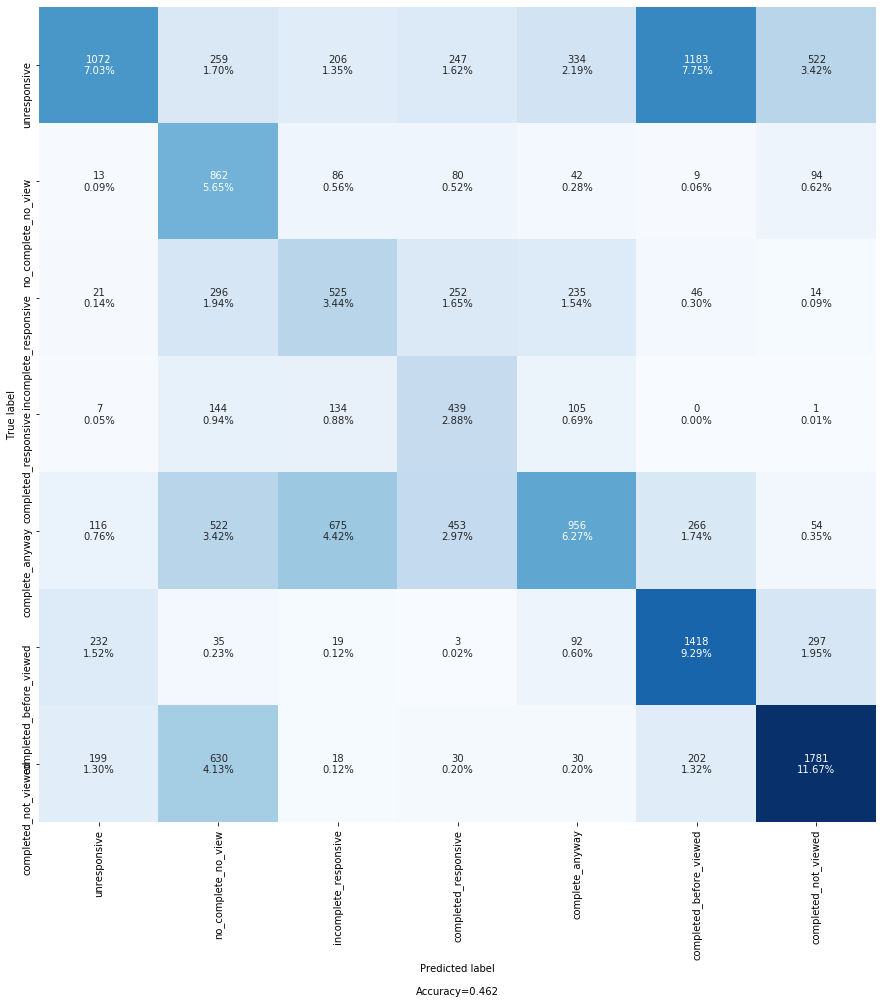

In [69]:
exploratory_training(labels=separation)

Here we can see an overall accuracy of 46.2%. Since classes are imbalanced, we have weighted each label inversely proportionaly to its proportion. With seven label categories the accuracy is fairly low with a poor ability to distinguish between categories.

In particular we have low f1-scores for incomplete responsive, completed responsive and unresponsive.

This could be due to the way the labels have been categorised which for these three were manually generated, or that these labels are simply too similar to distinguish to a high degree of accuracy.

### 2. Predicting offer completion

Simplifying to a binary classification complete vs didn't complete:

1. Completed 
2. Didn't complete

0:	learn: 0.6788512	test: 0.6781514	best: 0.6781514 (0)	total: 27.1ms	remaining: 3m 9s
500:	learn: 0.3301816	test: 0.3435130	best: 0.3435130 (500)	total: 11.8s	remaining: 2m 33s
1000:	learn: 0.3150134	test: 0.3330669	best: 0.3330588 (997)	total: 23.4s	remaining: 2m 20s
1500:	learn: 0.3036249	test: 0.3291962	best: 0.3291653 (1474)	total: 36.8s	remaining: 2m 14s
bestTest = 0.3272770631
bestIteration = 1941
Shrink model to first 1942 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.8521237545883587'

'Weights: [1.7864302777647665, 2.2715685398612226]'

              precision    recall  f1-score   support

      failed       0.92      0.81      0.86      8809
   completed       0.78      0.91      0.84      6447

    accuracy                           0.85     15256
   macro avg       0.85      0.86      0.85     15256
weighted avg       0.86      0.85      0.85     15256



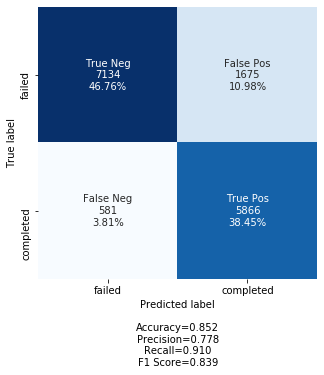

In [73]:
complete = {'completed_not_viewed': 1, 
        'completed_before_viewed': 1, 
        'complete_anyway': 1,
        'completed_responsive': 1,
        'incomplete_responsive': 0,
        'no_complete_no_view': 0,
        'unresponsive': 0}

labelling = {'failed':0, 'completed':1}

exploratory_training(labels=complete, labels_compact=labelling)

With a binary classification we can significantly improve accuracy, up to 85.2%.

However we now lose the ability to differentiate offers that would have been completed by customers anyway, leading to a reduction in revenue.

### 3. Predicting offer completion after viewing

Splitting into offers that were completed without or before being viewed:

1. Completed before viewing
2. Complete after viewing
2. Didn't complete

0:	learn: 1.0807158	test: 1.0814416	best: 1.0814416 (0)	total: 23.7ms	remaining: 2m 46s
500:	learn: 0.6562647	test: 0.6992498	best: 0.6992307 (499)	total: 11.6s	remaining: 2m 30s
1000:	learn: 0.6217277	test: 0.6858706	best: 0.6858606 (999)	total: 23.1s	remaining: 2m 18s
1500:	learn: 0.5943995	test: 0.6798700	best: 0.6798700 (1500)	total: 34.5s	remaining: 2m 6s
bestTest = 0.678678294
bestIteration = 1675
Shrink model to first 1676 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.7102779234399581'

'Weights: [1.7864302777647665, 3.435127223598289, 6.706259890979426]'

                 precision    recall  f1-score   support

         failed       0.93      0.76      0.84      8809
 complete after       0.60      0.61      0.60      3872
complete before       0.43      0.69      0.53      2575

       accuracy                           0.71     15256
      macro avg       0.65      0.69      0.66     15256
   weighted avg       0.76      0.71      0.73     15256



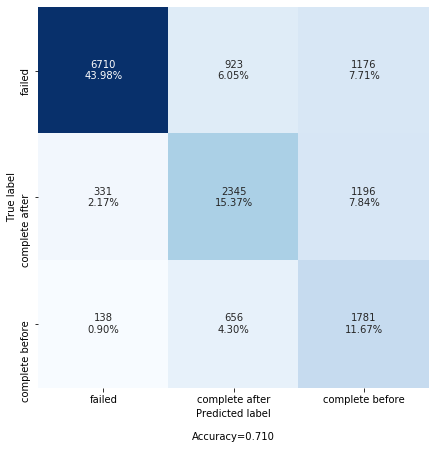

In [74]:
complete_from_view = {'completed_not_viewed': 2, 
                    'completed_before_viewed': 2, 
                    'complete_anyway': 1,
                    'completed_responsive': 1,
                    'incomplete_responsive': 0,
                    'no_complete_no_view': 0,
                    'unresponsive': 0}

labelling = {'failed': 0, 'complete after':1, 'complete before':2}

exploratory_training(labels=complete_from_view, labels_compact=labelling)

We now sacrifice some accuracy, dropping to 71%.

Precision and recall remains high for the failed to complete label. The offers we want to target (completed after viewing) are at approximately 0.6 precision, recall and f1-score.

### 4. Predicting responsiveness

Since incomplete responsive increases spending without loss of revenue from complete offers, we can assign labels to target this category as well:

1. Would have completed without having viewed offer
2. Responsive - spending was increased by viewing offer whether completed or not 
3. Unresponsive - Spending did not increase by viewing offer, and didn't complete 

0:	learn: 1.0842536	test: 1.0842492	best: 1.0842492 (0)	total: 25.6ms	remaining: 2m 59s
500:	learn: 0.7291346	test: 0.7441753	best: 0.7441753 (500)	total: 11.5s	remaining: 2m 28s
1000:	learn: 0.6970495	test: 0.7305905	best: 0.7305905 (1000)	total: 22.7s	remaining: 2m 16s
1500:	learn: 0.6720011	test: 0.7255659	best: 0.7255058 (1492)	total: 42.3s	remaining: 2m 34s
bestTest = 0.725237473
bestIteration = 1552
Shrink model to first 1553 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.6310304142632407'

'Weights: [2.5247252747252746, 2.3938300276173736, 5.371241461868882]'

                 precision    recall  f1-score   support

   Unresponsive       0.78      0.65      0.71      6713
     responsive       0.61      0.49      0.54      5138
complete before       0.50      0.80      0.61      3405

       accuracy                           0.63     15256
      macro avg       0.63      0.65      0.62     15256
   weighted avg       0.66      0.63      0.63     15256



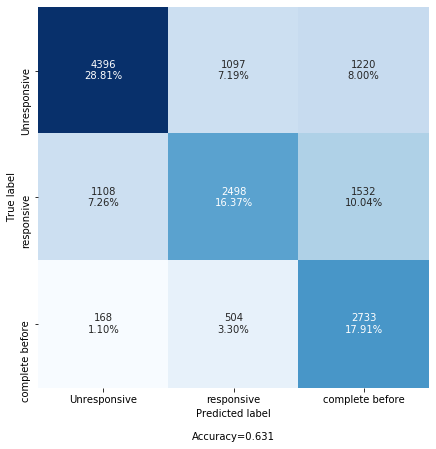

In [85]:
responsiveness = {'completed_not_viewed': 2, 
        'completed_before_viewed': 2, 
        'complete_anyway': 2,
        'completed_responsive': 1,
        'incomplete_responsive': 1,
        'no_complete_no_view': 0,
        'unresponsive': 0}

labelling = {'Unresponsive':0, 'responsive':1, 'complete before':2}

exploratory_training(labels=responsiveness, labels_compact=labelling)

Again accuracy drops further here, it appears that pure responsiveness to an offer is fairly difficult to categorise with precision of 65% and only recall of 51%.

### 5. Predicting responsiveness binary

Simplyfying further to target only offers that increase spending over base spend rate:

1. Responsive
2. Unresponsive

0:	learn: 0.6882945	test: 0.6891379	best: 0.6891379 (0)	total: 22ms	remaining: 2m 34s
500:	learn: 0.5465024	test: 0.5644353	best: 0.5644199 (498)	total: 14.4s	remaining: 3m 6s
1000:	learn: 0.5277505	test: 0.5561034	best: 0.5560988 (999)	total: 28.7s	remaining: 2m 52s
1500:	learn: 0.5126310	test: 0.5529062	best: 0.5528876 (1498)	total: 54.7s	remaining: 3m 20s
2000:	learn: 0.4992324	test: 0.5515028	best: 0.5514419 (1977)	total: 1m 24s	remaining: 3m 31s
bestTest = 0.5512194693
bestIteration = 2047
Shrink model to first 2048 iterations.



'Learning Rate set to: 0.02999999933'

'Accuracy Score: 0.7171604614577871'

'Weights: [1.7174475941728773, 2.3938300276173736]'

              precision    recall  f1-score   support

Unresponsive       0.82      0.74      0.78     10118
  Responsive       0.57      0.67      0.62      5138

    accuracy                           0.72     15256
   macro avg       0.69      0.71      0.70     15256
weighted avg       0.73      0.72      0.72     15256



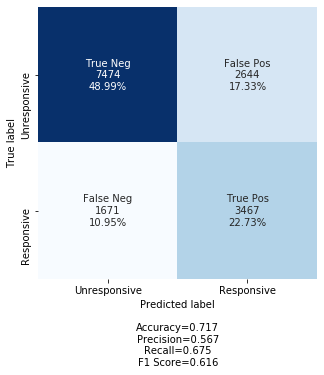

In [86]:
responsiveness2 = {'completed_not_viewed': 0, 
        'completed_before_viewed': 0, 
        'complete_anyway': 0,
        'completed_responsive': 1,
        'incomplete_responsive': 1,
        'no_complete_no_view': 0,
        'unresponsive': 0}

labelling = {'Unresponsive':0, 'Responsive':1}

exploratory_training(labels=responsiveness2, labels_compact=labelling)

With a binary classification targetting responsive, we have a better accuracy level and higher responsiveness recall.

## Further Analysis

To further continue with the analysis, we will perform cross validation and grid search to optimize parameters for two cases:

1. Binary classification (default paramater accuracy 85.2%)
    * Complete
    * Not complete 
    

2. Classification (default parameter accuracy 71%)
    * Complete before viewing
    * Complete after viewing
    * Not completing

# OLD STUFF KEEP FOR ANALYSIS ------------------------------------>

In [111]:
df[['completed_not_viewed', 'complete_anyway', 'completed_responsive', 'incomplete_responsive', 'incomplete_not_responsive']]

,completed_not_viewed,complete_anyway,completed_responsive,incomplete_responsive,incomplete_not_responsive
0,0,0,True,0,0
1,0,0,False,1,0
2,0,1,False,0,0
3,0,0,False,0,0
4,0,0,False,0,0
...,...,...,...,...,...
76272,0,0,False,0,1
76273,0,0,False,0,1
76274,0,0,True,0,0
76275,0,0,False,0,1


In [293]:
df['total labeles'].value_counts()

1    69530
0     6747
Name: total labeles, dtype: int64

In [232]:
df['total labeles'].value_counts()

1    69530
0     6747
Name: total labeles, dtype: int64

In [267]:
df[(df['incomplete_not_responsive']==1) & (df.viewed_spend==0)][['viewed_days_left', 'amount_per_day_offer', 'amount_per_day_not_offer', 'completed', 'viewed', 'time_days', 'received_spend', 'viewed_spend', 'duration', 'difficulty',
                                                   'completed_not_viewed', 'completed_before_viewed', 'complete_anyway', 'completed_responsive', 'incomplete_responsive', 'incomplete_not_responsive', 'no_complete_no_view', 'amount_per_day_not_offer']].viewed_spend.value_counts(0)

0.0    8070
Name: viewed_spend, dtype: int64

In [268]:
df[(df['total labeles']==0) & (df.viewed_spend==0)][['viewed_days_left', 'amount_per_day_offer', 'amount_per_day_not_offer', 'completed', 'viewed', 'time_days', 'received_spend', 'viewed_spend', 'duration', 'difficulty',
                                                   'completed_not_viewed', 'completed_before_viewed', 'complete_anyway', 'completed_responsive', 'incomplete_responsive', 'incomplete_not_responsive', 'no_complete_no_view', 'amount_per_day_not_offer']].viewed_spend.value_counts()

0.0    6747
Name: viewed_spend, dtype: int64

In [281]:
# no viewed spend
df[(df['total labeles']==0)][['viewed_days_left', 'amount_per_day_offer', 'amount_per_day_not_offer', 'completed', 'viewed', 'time_days', 'received_spend', 'viewed_spend', 'duration', 'difficulty',
                                                   'completed_not_viewed', 'completed_before_viewed', 'complete_anyway', 'completed_responsive', 'incomplete_responsive', 'incomplete_not_responsive', 'no_complete_no_view', 'amount_per_day_not_offer']].head(100)

,viewed_days_left,amount_per_day_offer,amount_per_day_not_offer,completed,viewed,time_days,received_spend,viewed_spend,duration,difficulty,completed_not_viewed,completed_before_viewed,complete_anyway,completed_responsive,incomplete_responsive,incomplete_not_responsive,no_complete_no_view,amount_per_day_not_offer
9,6.25,NaN,NaN,0.0,1.0,0.0,0.00,0.0,7.0,10.0,0,False,0,False,False,False,0,NaN
13,9.50,NaN,NaN,0.0,1.0,0.0,0.00,0.0,10.0,10.0,0,False,0,False,False,False,0,NaN
18,1.50,NaN,NaN,0.0,1.0,0.0,0.00,0.0,5.0,10.0,0,False,0,False,False,False,0,NaN
40,3.75,NaN,NaN,0.0,1.0,0.0,0.00,0.0,10.0,20.0,0,False,0,False,False,False,0,NaN
54,2.75,NaN,NaN,0.0,1.0,0.0,0.00,0.0,7.0,10.0,0,False,0,False,False,False,0,NaN
78,0.00,6.301667,0.000000,0.0,1.0,24.0,0.00,0.0,7.0,5.0,0,False,0,False,False,False,0,0.000000
84,0.00,NaN,NaN,0.0,1.0,0.0,0.67,0.0,7.0,5.0,0,False,0,False,False,False,0,NaN
90,3.00,NaN,NaN,0.0,1.0,0.0,0.00,0.0,7.0,10.0,0,False,0,False,False,False,0,NaN
102,0.00,0.000000,4.044615,0.0,1.0,7.0,2.81,0.0,3.0,0.0,0,False,0,False,False,False,0,4.044615
110,0.00,15.936000,5.968125,0.0,1.0,17.0,0.00,0.0,3.0,0.0,0,False,0,False,False,False,0,5.968125


In [280]:
df[(df['incomplete_not_responsive']==1) & (df.viewed_spend ==0)][['viewed_days_left', 'amount_per_day_offer', 'amount_per_day_not_offer', 'completed', 'viewed', 'time_days', 'received_spend', 'viewed_spend', 'duration', 'difficulty',
                                                   'completed_not_viewed', 'completed_before_viewed', 'complete_anyway', 'completed_responsive', 'incomplete_responsive', 'incomplete_not_responsive', 'no_complete_no_view', 'amount_per_day_not_offer']]

,viewed_days_left,amount_per_day_offer,amount_per_day_not_offer,completed,viewed,time_days,received_spend,viewed_spend,duration,difficulty,completed_not_viewed,completed_before_viewed,complete_anyway,completed_responsive,incomplete_responsive,incomplete_not_responsive,no_complete_no_view,amount_per_day_not_offer
5,4.00,0.109,0.823529,0.0,1.0,14.0,0.00,0.0,4.0,0.0,0,False,0,False,False,True,0,0.823529
7,5.00,0.109,0.311111,0.0,1.0,21.0,0.06,0.0,10.0,20.0,0,False,0,False,False,True,0,0.311111
14,3.00,0.000,0.000000,0.0,1.0,7.0,0.00,0.0,5.0,10.0,0,False,0,False,False,True,0,0.000000
15,2.75,0.000,0.000000,0.0,1.0,14.0,0.00,0.0,4.0,0.0,0,False,0,False,False,True,0,0.000000
16,4.75,0.000,0.000000,0.0,1.0,17.0,0.00,0.0,7.0,10.0,0,False,0,False,False,True,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76270,5.00,NaN,0.000000,0.0,1.0,21.0,0.00,0.0,5.0,10.0,0,False,0,False,False,True,0,0.000000
76272,4.00,NaN,0.000000,0.0,1.0,21.0,0.00,0.0,4.0,0.0,0,False,0,False,False,True,0,0.000000
76273,5.00,NaN,0.000000,0.0,1.0,24.0,0.00,0.0,5.0,10.0,0,False,0,False,False,True,0,0.000000
76275,4.25,NaN,0.000000,0.0,1.0,24.0,0.00,0.0,5.0,10.0,0,False,0,False,False,True,0,0.000000


In [31]:
df.remaining_to_complete.value_counts().head()

10.0    20246
0.0     13992
5.0      9237
7.0      5999
20.0     1881
Name: remaining_to_complete, dtype: int64

In [32]:
df.viewed_days_left

0        6.75
1        1.00
2        7.00
3        0.00
4        9.75
         ... 
76272    4.00
76273    5.00
76274    9.50
76275    4.25
76276    5.00
Name: viewed_days_left, Length: 76277, dtype: float64

In [ ]:
df = joblib.load('../../data/interim/transcript_final_optimised.joblib')
df = label_creater(df, label_grid=labels)
cat_features = [0,4,5,92,93,94,95,96,97]

df.sort_values('time_days', inplace=True)

X = df.drop('label', axis=1)
y = df.label

cv = cv_method(X_train, y_train, 'time')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

weights = [df.label.value_counts().sum() / df.label.value_counts()[i] for i in range(0, df.label.nunique())]

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)
